In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, metrics, activations
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def normalize(x):
  # Normalizes to [-1, 1]
  return (x - 127.5) / 127.5

In [3]:
# Loads data for MNIST

BATCH_SIZE = 64

(x_train, y_train), (x_validation, y_validation) = mnist.load_data()

x_validation, y_validation = x_validation[:500], y_validation[:500]

x_train, x_validation = normalize(x_train), normalize(x_validation)

x_train, x_validation = np.reshape(x_train, (x_train.shape[0], -1)), np.reshape(x_validation, (x_validation.shape[0], -1))

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
         .shuffle(buffer_size = 50_000) \
         .batch(BATCH_SIZE, drop_remainder=True)

# Klassifisering

In [4]:
# Oppvarming
# Definer en classifier-modell for MNIST. Denne arkitekturen kan du enkelt gjøre
# om til discriminator-modell senere ved å endre antall outputs fra 10 til 1.
#
# Bruk et enkelt nevralt nettverk her (ikke CNNs). 
#
# Sikt gjerne på minst 97 % validation accuracy.

classifier = Sequential([
                         layers.Dense(units = 256, activation="relu"),
                         layers.Dense(units = 10)
                         ])

classifier.compile(metrics = [metrics.SparseCategoricalAccuracy()])


Epoch 0
16/16 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9600
Epoch 1
16/16 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9440
Epoch 2
16/16 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9680
Epoch 3
16/16 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9600
Epoch 4
16/16 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9580
Epoch 5
16/16 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9700
Epoch 6
16/16 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9680
Epoch 7
16/16 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9700
Epoch 8
16/16 [==============================] - 0s 2ms/

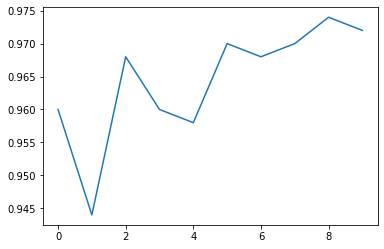

In [5]:
# Her hadde det desidert enkleste vært å trene classifier-modellen med 
# classifier.fit(). I stedet demonstreres hvordan man kan trene
# modellen ved hjelp av det funksjonelle API-et til Tensorflow. Dette API-et
# blir nyttig med en gang man skal ha et mer kompliserte treningssteg, slik som 
# for GAN. 
#
# Her brukes en GradientTape for å overvåke utregningen som inngår under tape-
# uttrykket (forward pass gjennom modellen). Deretter kan man hente ut 
# gradientene for en utregning Y med hensyn til variablene W, og bruke 
# gradientene til å oppdatere modellen som vanlig (med apply_gradients). 

classification_optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step_classifier(batch_x, batch_y):
  with tf.GradientTape() as tape:

    output = classifier(batch_x)

    loss = losses.sparse_categorical_crossentropy(y_true = batch_y, y_pred = output, from_logits=True) #0 # TODO 

  gradients = tape.gradient(loss, classifier.trainable_variables)
  classification_optimizer.apply_gradients(zip(gradients, classifier.trainable_variables))

  return loss,  


validation_accuracy = []
for epoch in range(10):
  
  print("Epoch", epoch)
  for (batch_x, batch_y) in dataset:
    train_step_classifier(batch_x, batch_y)
  
  accuracy = classifier.evaluate(x_validation, y_validation)[1]
  validation_accuracy.append(accuracy)

plt.plot(validation_accuracy)

# General Adverserial Networks

In [6]:
# Definer diskriminator-modellen. I motsetning til klassifikatoren skal denne gi
# ut én output-verdi: hvor vidt bilde-input-en er autentisk (true) eller 
# generert (false). 

discriminator = Sequential([
    layers.Dense(units = 256, activation="relu"),
    layers.Dense(units = 128, activation="relu"),
    layers.Dense(units = 64, activation="relu"),
    layers.Dense(units = 1)                        
])

discriminator.compile()
discriminator.summary()

In [7]:
noise_dim = 20

# Definer generator-modellen. Denne skal ta inn en støy-vektor (en vektor med 
# størrelse lik noise_dim av tilfeldige flyttall) og gi ut et bilde. For MNIST
# må den dermed ha 28*28=784 outputs. 
#
# Du velger størrelsen på noise_dim selv. 

generator = Sequential([
    layers.Dense(units = 128, activation="relu"),
    layers.Dense(units = 256, activation="relu"),
    layers.Dense(units = 784, activation="tanh")                           
])

generator.compile()
generator.summary()

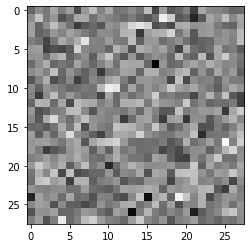

In [8]:
def to_image(img):
  return img.reshape([28, 28])

def show_image(img):
  img = to_image(img)
  plt.imshow(img, cmap='gray')
  plt.show()

def generate_noise(dim, batch_size = 1):
  return tf.random.normal([batch_size, dim])

# Generer og viser et bilde fra den utrente generatoren

generated_image = generator(generate_noise(noise_dim)).numpy()

show_image(generated_image)


In [9]:
# Definerer optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [10]:
# Implementer treningssteget. Denne tar inn én batch med treningsbilder.
# Denne skal generere et sett med falske bilder. Diskriminatoren skal vurdere
# både de falske og de ekte bildesettene. Begge modellene skal oppdateres
# ut fra vurderingen til diskriminatoren.
#
# Tips: bruk gjerne en Optimizer for hver av generator-modellen og diskriminator-
# modellen.
#
# Returnerer: 
# D_loss: loss-verdien for diskriminatoren
# G_loss: loss-verdien for generatoren
# P_real: Diskriminatoren sin accuracy for ekte bilder
# P_fake: Diskriminatoren sin accuracy for falske bilder

@tf.function
def train_step(real_images):
  noise = generate_noise(dim = noise_dim, batch_size = BATCH_SIZE)

  with tf.GradientTape(persistent=True) as tape:

    fake_images = generator(noise)

    prediction_real = discriminator(real_images)
    prediction_fake = discriminator(fake_images)

    discriminator_loss = losses.binary_crossentropy(y_true=tf.ones_like(prediction_real), y_pred=prediction_real, from_logits=True) + losses.binary_crossentropy(y_true=tf.zeros_like(prediction_fake), y_pred=prediction_fake, from_logits=True)
    generator_loss = losses.binary_crossentropy(y_true=tf.ones_like(prediction_fake), y_pred=prediction_fake, from_logits=True)

  gradients_of_generator = tape.gradient(generator_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

  gradients_of_discriminator = tape.gradient(discriminator_loss, discriminator.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  D_loss = tf.reduce_mean(discriminator_loss)
  G_loss = tf.reduce_mean(generator_loss)
  P_real = tf.reduce_mean(activations.sigmoid(prediction_real))
  P_fake = 1 - tf.reduce_mean(activations.sigmoid(prediction_fake))

  return D_loss, G_loss, P_real, P_fake


In [11]:
def show_image_grid(images):
  N = images.shape[0]

  fig = plt.figure(figsize=(3, 3))
  fig.set_size_inches(10, 10)

  for i in range(N):
      plt.subplot(3, 3, i+1)
      img = to_image(images[i])
      plt.imshow(img, cmap="gray")
      plt.axis('off')

  plt.show()

In [12]:
EPOCHS = 100

noise_for_training_visualization = generate_noise(noise_dim, batch_size = 9)

for epoch in range(EPOCHS):

  print("Epoch", epoch),

  for step, (x_train, _) in enumerate(dataset):
    Ld, Lg, Pr, Pf = train_step(x_train)

    if step % 100 == 0:
      print("Step {}. Ld={}, Lg=={}, Pr={}, Pf={}".format(step, Ld, Lg, Pr, Pf))

  show_image_grid(generator(noise_for_training_visualization).numpy())
  

Output hidden; open in https://colab.research.google.com to view.

In [13]:
# Denne kan du bruke til å utforske generatoren!

from ipywidgets import interact

p1 = generate_noise(noise_dim)
p2 = generate_noise(noise_dim)
p3 = generate_noise(noise_dim)

@interact(k1=(0, 1.0), k2=(0, 1.0))
def g(k1, k2):
    p = p1 + k1 * (p2 - p1) + k2 * (p3 - p1)
    show_image(generator(p).numpy())

interactive(children=(FloatSlider(value=0.5, description='k1', max=1.0), FloatSlider(value=0.5, description='k…